In [1]:
import utils
import r_pca
import numpy as np
from pylab import plt

%load_ext autoreload
%autoreload 2

In [50]:
d = 10
n = 2 ** d
left = 0
right = 1
signal = utils.values(np.sqrt, left, right, n)
modes = [2] * d

In [51]:
filters, sparse_parts, ranks = utils.wtt_rpca_v3(
    signal,
    d,
    modes,
    ranks=None,
    eps=1e-6,
    lambda_scale=2.5,
    verbose=False
)

In [52]:
[u.shape for u in filters]

[(2, 2),
 (4, 4),
 (8, 8),
 (14, 14),
 (14, 14),
 (14, 14),
 (12, 12),
 (10, 10),
 (8, 8),
 (4, 4)]

In [53]:
[u.shape for u in sparse_parts]

[(2, 512),
 (4, 256),
 (8, 128),
 (16, 64),
 (32, 32),
 (64, 16),
 (128, 8),
 (256, 4),
 (512, 2),
 (1024, 1)]

In [54]:
[u.data.size for u in sparse_parts]

[22, 43, 42, 17, 1, 8, 12, 21, 0, 0]

In [55]:
wtt_result = utils.wtt_apply_rpca_v3(
    signal,
    d,
    filters,
    sparse_parts,
    modes,
    ranks
)

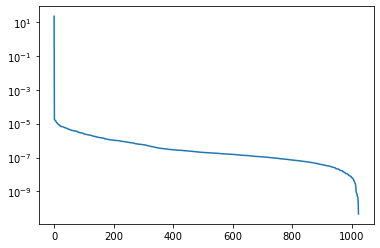

In [56]:
plt.plot(np.arange(wtt_result.size), np.flip(np.sort(np.abs(wtt_result))))
plt.yscale('log')
plt.show()

In [57]:
iwtt_result = utils.iwtt_apply_rpca_v3(
    wtt_result,
    d,
    filters,
    sparse_parts,
    modes,
    ranks
)

In [58]:
np.linalg.norm(signal - iwtt_result)

1.754480842543126e-14

Восстановим:

In [59]:
(np.abs(wtt_result) <= 1e-6).sum()

809

In [60]:
wtt_result[np.abs(wtt_result) <= 1e-6] = 0
iwtt_result = utils.iwtt_apply_rpca_v3(
    wtt_result,
    d,
    filters,
    sparse_parts,
    modes,
    ranks
)
print(np.linalg.norm(signal - iwtt_result))

8.890309034564021e-06


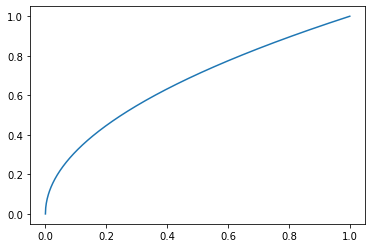

In [61]:
#plt.plot(np.linspace(left, right, n), signal)
plt.plot(np.linspace(left, right, n), iwtt_result)

Тестируем тензоризованный препроцессинг.

In [62]:
low_rank_part, sparse_parts, ranks = r_pca.wtt_rpca_preprocessing(
    signal,
    d,
    modes,
    lambda_scale=2.5 #как выше, ведь идея такая же
)

Current step 0
Current step 1
Current step 2
Current step 3
Current step 4
Current step 5
Current step 6
Current step 7
Current step 8
Current step 9


In [63]:
low_rank_part

array([0.08130122, 0.08255045, 0.08375563, ..., 0.99898575, 0.99945595,
       0.99991889])

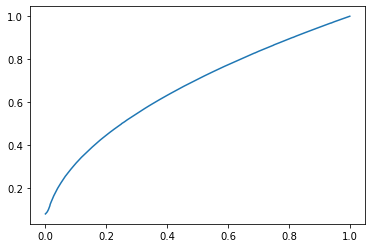

In [64]:
plt.plot(np.linspace(left, right, n), low_rank_part)
plt.show()

Что-то очень похожее на оригинальный корень, между прочим!

In [65]:
np.linalg.norm(low_rank_part - signal)

0.11485710327180632

Посмотрим на характеристики разложения:

In [66]:
[s.data.size for s in sparse_parts]

[22, 38, 29, 11, 0, 6, 11, 26, 0, 0]

In [67]:
ranks

[2, 3, 4, 5, 4, 4, 4, 3, 2]

Попробуем теперь разложить малоранговую часть, что ли...

In [68]:
filters, true_ranks = utils.wtt_filter(
    low_rank_part,
    d,
    modes,
    ranks=ranks
)

In [69]:
true_ranks

[2, 3, 4, 5, 4, 4, 4, 3, 2]

In [70]:
wtt_res = utils.wtt_apply(
    low_rank_part,
    d,
    filters,
    modes,
    true_ranks
)

Что получилось:

In [71]:
np.max(wtt_res[1:])

2.4909398560856058e-15

Все коэффициенты, кроме первого --- нули! А ранги при этом крошечные.

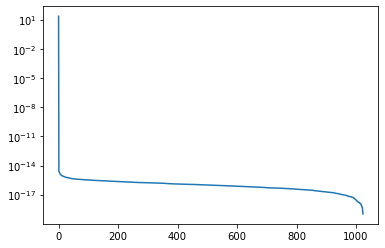

In [72]:
plt.plot(np.arange(wtt_res.size), np.flip(np.sort(np.abs(wtt_res))))
plt.yscale('log')
plt.show()

In [73]:
zeroed_coeffs = np.zeros_like(wtt_res)
zeroed_coeffs[0] = wtt_res[0]

iwtt_res = utils.iwtt_apply(
    zeroed_coeffs,
    d,
    filters,
    modes,
    true_ranks
)

print(np.linalg.norm(iwtt_res - low_rank_part))

2.3192420139693152e-14


Восстановим корень:

In [74]:
signal - utils.subtract_sparse_parts(signal, d, modes, sparse_parts)

array([-0.08135713, -0.05120038, -0.03957119, ...,  0.        ,
        0.        ,  0.        ])

Всё же у нас приближённое разложение $A = L + S_1 + \ldots + S_d$ (параметр ```tol``` в алгоритме).

In [75]:
signal_restored = utils.add_sparse_parts(iwtt_res, d, modes, sparse_parts)
np.linalg.norm(signal - signal_restored)

0.004540052091185303

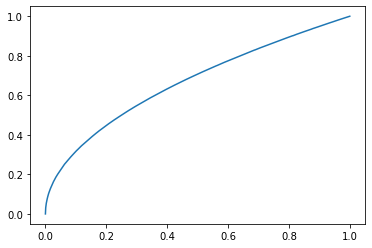

In [76]:
plt.plot(np.linspace(left, right, n), signal_restored)
plt.show()

Теперь посмотрим на простое 2D:

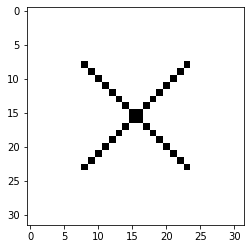

In [77]:
cross = np.full((32, 32), 1.)
for i in range(8, 24):
    cross[i, i] = 0.
    cross[i, 31 - i] = 0.
plt.imshow(cross, cmap='gray')

In [78]:
d = 5
modes = [2] * d

vector, vector_modes = utils.matrix_to_vector(cross, d, modes)

In [79]:
low_rank_part, sparse_parts, ranks = r_pca.wtt_rpca_preprocessing(
    vector,
    d,
    vector_modes,
    lambda_scale=2
)

Current step 0
Current step 1
Current step 2
Current step 3
Current step 4


In [80]:
matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)

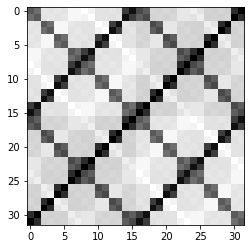

In [81]:
plt.imshow(matrix, cmap='gray')

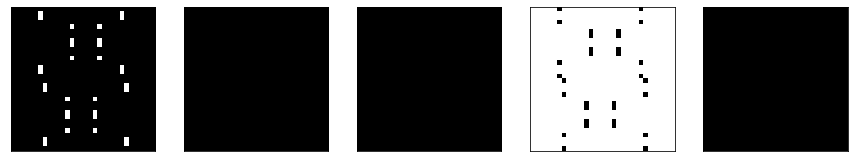

In [82]:
fig = plt.figure(figsize=(15, 3))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(
        sparse_parts[i].toarray().reshape((32, 32), order='F'),
        #sparse_parts[i].toarray(),
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])

In [83]:
[s.data.size for s in sparse_parts]

[32, 0, 0, 64, 0]

In [84]:
ranks

[2, 3, 3, 1]

In [85]:
matrix

array([[0.99999993, 0.99999994, 1.        , ..., 0.99999999, 0.9999999 ,
        0.99999988],
       [0.99999994, 0.99999993, 1.        , ..., 0.99999999, 0.99999988,
        0.9999999 ],
       [1.        , 1.        , 0.99999993, ..., 0.99999988, 0.99999999,
        0.99999999],
       ...,
       [0.99999999, 0.99999999, 0.99999988, ..., 0.99999993, 1.        ,
        1.        ],
       [0.9999999 , 0.99999988, 0.99999999, ..., 1.        , 0.99999993,
        0.99999994],
       [0.99999988, 0.9999999 , 0.99999999, ..., 1.        , 0.99999994,
        0.99999993]])

In [86]:
np.max(matrix - np.ones_like(matrix))

1.37506863673309e-08

In [87]:
(np.sum([s.toarray().reshape((32, 32), order='F') for s in sparse_parts], axis=0) + matrix - cross)

array([[-7.26261529e-08, -6.21613622e-08,  4.27539337e-10, ...,
        -1.10559626e-08, -9.68405208e-08, -1.20088094e-07],
       [-6.21613622e-08, -7.26261529e-08, -7.12143011e-10, ...,
        -8.63219152e-09, -1.20088094e-07, -9.68405207e-08],
       [ 4.27539115e-10, -7.12142789e-10, -7.26261538e-08, ...,
        -1.20088094e-07, -8.63219307e-09, -1.10559633e-08],
       ...,
       [-1.10559615e-08, -8.63219018e-09, -1.20088092e-07, ...,
        -7.26261518e-08, -7.12141457e-10,  4.27540892e-10],
       [-9.68405195e-08, -1.20088092e-07, -8.63219174e-09, ...,
        -7.12141235e-10, -7.26261526e-08, -6.21613608e-08],
       [-1.20088092e-07, -9.68405195e-08, -1.10559621e-08, ...,
         4.27540670e-10, -6.21613608e-08, -7.26261526e-08]])

In [88]:
np.linalg.norm(np.sum([s.toarray().reshape((32, 32), order='F') for s in sparse_parts], axis=0) + matrix - cross)

7.999998735544775